In [ ]:
from typing import Dict, Text

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

from sklearn.model_selection import train_test_split

## Import the data

In [ ]:
item_df = pd.read_csv('df_items.csv')
user_df = pd.read_csv('df_users.csv')
interaction_df = pd.read_csv('df_interactions.csv')
song_info_df = pd.read_csv('df_song_info.csv')

## Data Preparation

In [ ]:
# Construct song title to combine name and artist.
item_df = pd.merge(item_df, song_info_df, on='track_id')
item_df['song_title'] = item_df['name'] + ' by ' + item_df['artist']
item_df = item_df.drop(['name'], axis=1)

# Merge dataframes to get song title for interaction dataframe.
interaction_df = pd.merge(interaction_df, song_info_df, on='track_id')
interaction_df = pd.merge(interaction_df, user_df, on='user_id')
interaction_df['song_title'] = interaction_df['name'] + ' by ' + interaction_df['artist']

# Drop unused Columns
interaction_df = interaction_df.drop(['name', 'artist', 'previous_track_id'], axis=1)

In [ ]:
# Transforming the data types of song emotion and user segment to string
item_df['Emotion Quadrant'] = item_df['Emotion Quadrant'].astype(str)
interaction_df['segment'] = interaction_df['segment'].astype(str)

In [ ]:
# Check columns in interaction dataframe
interaction_df.columns

Index(['user_id', 'track_id', 'playcount', 'segment', 'song_title'], dtype='object')

In [ ]:
# Select columns to use for interaction (user) dataframe
i_cols = ['user_id', 'track_id', 'playcount', 'segment', 'song_title']

# Select columna to use for item (song) dataframe
s_cols = ['track_id', 'song_title', 'Emotion Quadrant', 'artist', 'year']

# Filter columns
song_df = item_df[s_cols]
interaction_df = interaction_df[i_cols]

In [ ]:
# Changes the data type of user_id and track_id to string by adding 'id_'.
interaction_df['user_id'] = 'id_' + interaction_df['user_id'].astype(str)
interaction_df['track_id'] = 'id_' + interaction_df['track_id'].astype(str)
song_df['track_id'] = 'id_' + song_df['track_id'].astype(str)

<ipython-input-11-0a736e00bd8d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song_df['track_id'] = 'id_' + song_df['track_id'].astype(str)


In [ ]:
# Extract heavt and light users 
heavy_user_df = interaction_df['user_id'].value_counts()[:600].index
light_user_df = interaction_df['user_id'].value_counts()[600:].index
heavy_user_listen_df = interaction_df.query('user_id in @heavy_user_df')
light_user_listen_df = interaction_df.query('user_id in @light_user_df')

In [ ]:
# Sort the dataFrame by user_id and unix_timestamp
heavy_user_listen_df = heavy_user_listen_df.sort_values(['user_id'])

In [ ]:
# Split into training and temporary sets (80% training, 20% temp)
train_df, tmp_df = train_test_split(heavy_user_listen_df, test_size=0.8, random_state=13)

# Further split the temporary set into training and validation sets (50% training, 50% validation)
val_df, test_df = train_test_split(tmp_df, test_size=0.5, random_state=13)

print("Training set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
print("Testing set shape:", test_df.shape)

Training set shape: (21224, 5)
Validation set shape: (10612, 5)
Testing set shape: (10612, 5)


In [ ]:
# Calculate the unique listener number of each song and the average playcount of each song
additional_features = train_df.groupby('track_id')\
                                .aggregate({'user_id':'count','playcount':'mean'})\
                                .rename(columns={'user_id':'total_listener', 'playcount':'avg_plays'})\
                                .reset_index()

additional_features['avg_plays'] = additional_features['avg_plays'].round(2)
additional_features

,track_id,total_listener,avg_plays
0,id_1000,2,2.50
1,id_10006,2,1.00
2,id_10019,1,1.00
3,id_10026,1,5.00
4,id_10029,1,7.00
...,...,...,...
7364,id_9990,3,1.67
7365,id_9992,2,1.00
7366,id_9994,1,1.00
7367,id_9998,1,1.00


In [ ]:
# Define columns to use in the song dataframe
columns = [
    'track_id',
    'song_title',
    'artist',
    'Emotion Quadrant',
    'total_listener',
    'avg_plays'
]


# Merge the additional features to the song dataframe
song_df = (song_df.merge(additional_features,
                    left_on='track_id', right_on='track_id',how = 'left'))

# kerge train, val, and test dataframes with the song dataframe

train_df = (train_df.merge(song_df[columns],
                    left_on='track_id', right_on='track_id',how = 'left'))

val_df = (val_df.merge(song_df[columns],
                    left_on='track_id', right_on='track_id',how = 'left'))

test_df = (test_df.merge(song_df[columns],
                    left_on='track_id', right_on='track_id',how = 'left'))

# Merge the light user dataframe with the song dataframe
light_user_ratings_df = (light_user_listen_df.merge(song_df[columns],
                                                left_on='track_id', right_on='track_id',how = 'left')
)

In [ ]:
# Drop unused columns
train_df_2 = train_df.drop(['playcount', 'song_title_x'],axis=1)\
                        .rename(columns={'song_title_y':'song_title'})

val_df_2 = val_df.drop(['playcount', 'song_title_x'],axis=1)\
                        .rename(columns={'song_title_y':'song_title'})

test_df_2 = test_df.drop(['playcount', 'song_title_x'],axis=1)\
                        .rename(columns={'song_title_y':'song_title'})

light_user_ratings_df_2 = light_user_ratings_df.drop(['playcount', 'song_title_x'],axis=1)\
                        .rename(columns={'song_title_y':'song_title'})

# Transform the data type of the year column to string
song_df['year'] = song_df['year'].astype(str)

In [ ]:
# Convert pandas dataframes to tensorFlow datasets
train_tf = tf.data.Dataset.from_tensor_slices(train_df_2.to_dict('list'))
val_tf = tf.data.Dataset.from_tensor_slices(val_df_2.to_dict('list'))
test_tf = tf.data.Dataset.from_tensor_slices(test_df_2.to_dict('list'))
song_tf = tf.data.Dataset.from_tensor_slices(dict(song_df[columns].to_dict('list')))

In [ ]:
# Covert tf dataframe to this json formated tf dataframe.
# Format required for training the model

train = train_tf.map(lambda x: {
    "user_id": x["user_id"],
    "track_id": x["track_id"],
    "song_title": x["song_title"],
    "segment": x["segment"],
    "artist": x["artist"],
    "Emotion Quadrant": x["Emotion Quadrant"],
    "total_listener": x["total_listener"],
    "avg_plays": x["avg_plays"]
    })

val = val_tf.map(lambda x: {
    "user_id": x["user_id"],
    "track_id": x["track_id"],
    "song_title": x["song_title"],
    "segment": x["segment"],
    "artist": x["artist"],
    "Emotion Quadrant": x["Emotion Quadrant"],
    "total_listener": x["total_listener"],
    "avg_plays": x["avg_plays"]
    })

test = test_tf.map(lambda x: {
    "user_id": x["user_id"],
    "track_id": x["track_id"],
    "song_title": x["song_title"],
    "segment": x["segment"],
    "artist": x["artist"],
    "Emotion Quadrant": x["Emotion Quadrant"],
    "total_listener": x["total_listener"],
    "avg_plays": x["avg_plays"]
    })

song = song_tf.map(lambda x: {
    "track_id": x["track_id"],
    "song_title": x["song_title"],
    "Emotion Quadrant": x["Emotion Quadrant"],
    "artist": x["artist"],
    "total_listener": x["total_listener"],
    "avg_plays": x["avg_plays"]
    })

In [ ]:
# Batching the entier dataframe for memory safety
tf.random.set_seed(13)

cached_train = train.batch(1000).cache()
cached_val = val.batch(1000).cache()
cached_test = test.batch(1000).cache()

In [ ]:
# Set some variables to the model such as the input/output dimensions of the embeddings.

user_ids = train_tf.batch(1_000).map(lambda x: x["user_id"])
song_ids = song_tf.batch(1_000).map(lambda x: x["track_id"])
segment_ids = train_tf.batch(1_000).map(lambda x: x["segment"])
title_song_ids = song_tf.batch(1_000).map(lambda x: x["song_title"])
artist_ids = song_tf.batch(1_000).map(lambda x: x["artist"])
Emotion_Quadrant_ids = song_tf.batch(1_000).map(lambda x: x["Emotion Quadrant"])

# Getting a list of the unique values for each variable
unique_user_ids = np.unique(np.concatenate(list(user_ids)))
unique_song_ids = np.unique(np.concatenate(list(song_ids)))
unique_segment_ids = np.unique(np.concatenate(list(segment_ids)))
unique_title_song_ids = np.unique(np.concatenate(list(title_song_ids)))
unique_artist_ids = np.unique(np.concatenate(list(artist_ids)))
unique_Emotion_Quadrant_ids = np.unique(np.concatenate(list(Emotion_Quadrant_ids)))

In [ ]:
# Calculate the number of total listeners of each song
total_listener = np.concatenate(list(train_tf.map(lambda x: x["total_listener"]).batch(1000)))

max_total_listener = total_listener.max()
min_total_listener = total_listener.min()

total_listener_buckets = np.linspace(
    min_total_listener, max_total_listener, num=20, dtype = int
)

total_listener_buckets

array([ 1,  3,  5,  8, 10, 13, 15, 17, 20, 22, 25, 27, 30, 32, 34, 37, 39,
       42, 44, 47])

In [ ]:
# Calculate the number of the average playcount of each song
avg_plays = np.concatenate(list(train_tf.map(lambda x: x["avg_plays"]).batch(1000)))

max_avg_plays = avg_plays.max()
min_avg_plays = avg_plays.min()

avg_plays_buckets = np.linspace(
    min_avg_plays, max_avg_plays, num=5, dtype = int
)

avg_plays_buckets

array([ 1, 22, 44, 65, 87])

## Modeling

In [ ]:
class UserModel(tf.keras.Model):

    def __init__(self):

        super().__init__()

        self.user_query_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), name = 'user_input', dtype = tf.string),
            tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(
                input_dim = len(unique_user_ids) + 1,
                output_dim = 32),
            tf.keras.layers.Flatten(name='FlattenUser')
            ])

        self.song_query_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), name = 'song_input', dtype = tf.string),
            tf.keras.layers.StringLookup(vocabulary=unique_song_ids, mask_token=None),
            tf.keras.layers.Embedding(
                input_dim = len(unique_song_ids) + 1,
                output_dim = 32),
            tf.keras.layers.Flatten(name='FlattenUserSong')
        ])

        # user_segment
        self.segment_query_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), name = 'segment_input', dtype = tf.string),
            tf.keras.layers.StringLookup(vocabulary=unique_segment_ids, mask_token=None),
            tf.keras.layers.Embedding(
                input_dim = len(unique_segment_ids) + 1,
                output_dim = 32),
            tf.keras.layers.Flatten(name='FlattenUserSong')
        ])


    def call(self, inputs):

        return tf.concat([
                self.user_query_model(inputs["user_id"]),
                self.song_query_model(inputs["track_id"]),
                self.segment_query_model(inputs["segment"]),
            ], axis = 1)

In [27]:
UserModel()

In [28]:
class SongModel(tf.keras.Model):

    def __init__(self):
        super().__init__()

        self.song_candidate_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), name = 'track_id', dtype = tf.string),
            tf.keras.layers.StringLookup(vocabulary=unique_song_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_song_ids) + 1, 32),
            tf.keras.layers.Flatten(name='FlattenCandidateTitle')
        ])

        self.emotion_candidate_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), name = 'Emotion Quadrant', dtype = tf.string),
            tf.keras.layers.StringLookup(vocabulary=unique_Emotion_Quadrant_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_Emotion_Quadrant_ids) + 1, 32),
            tf.keras.layers.Flatten(name='FlattenCandidateTitle')
        ])

        self.artitst_candidate_model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), name = 'artist', dtype = tf.string),
            tf.keras.layers.StringLookup(vocabulary=unique_artist_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_artist_ids) + 1, 32),
            tf.keras.layers.Flatten(name='FlattenCandidateTitle')
        ])

        self.title_text_embedding = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), name='title_text', dtype = tf.string),
            tf.keras.layers.StringLookup(vocabulary=unique_title_song_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_title_song_ids)+1, 32, mask_zero=True),
            tf.keras.layers.Flatten(name='FlattenCandidatesTitle'),
    ])
        self.total_listerners = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), name = 'total_listener_buckets_input', dtype = tf.int64),
            tf.keras.layers.Discretization(total_listener_buckets.tolist()),
            tf.keras.layers.Embedding(len(total_listener_buckets) + 1, 32),
            tf.keras.layers.Flatten(name='FlattenMerchantMonthlySales')
            ])

    def call(self, titles):
        return tf.concat([
            self.song_candidate_model(titles['track_id']),
            self.title_text_embedding(titles['song_title']),
            self.artitst_candidate_model(titles['artist']),
            self.total_listerners(titles['total_listener']),
            self.emotion_candidate_model(titles['Emotion Quadrant']),
            ], axis = 1)

In [29]:
SongModel()

In [30]:
class CandidatesModel(tfrs.models.Model):

    def __init__(self):

        super().__init__()

        self.query_model = tf.keras.Sequential([
            UserModel(),
            tf.keras.layers.Dense(32)
        ])
        self.candidate_model = tf.keras.Sequential([
            SongModel(),
            tf.keras.layers.Dense(32)
        ])

        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=song.batch(128).map(self.candidate_model),
            ),
        )

    def compute_loss(self, features, training=False):

        query_embeddings = self.query_model({
            "user_id": features["user_id"],
            'track_id': features["track_id"],
            'segment': features["segment"]
        })

        candidates_embeddings = self.candidate_model({
            'track_id': features["track_id"],
            'song_title': features["song_title"],
            'total_listener': features["total_listener"],
            'artist': features["artist"],
            'Emotion Quadrant': features["Emotion Quadrant"]
        })

        return self.task(query_embeddings, candidates_embeddings)

## Train

In [31]:
candidates_model = CandidatesModel()

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7),
    tf.keras.callbacks.ModelCheckpoint(filepath='./logs/models', save_weights_only=True, save_best_only=True, save_freq="epoch",),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

candidates_model.compile(
    run_eagerly=True,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
)

In [ ]:
start_train = True

if start_train:
    history = candidates_model.fit(
        x=cached_train,
        epochs=100,
        verbose=True,
        batch_size=100,
        validation_data=cached_val,
        callbacks=callbacks,
        use_multiprocessing=True,
        workers=12
    )

Epoch 1/100
22/22 [==============================] - 116s 5s/step - factorized_top_k/top_1_categorical_accuracy: 0.0523 - factorized_top_k/top_5_categorical_accuracy: 0.1811 - factorized_top_k/top_10_categorical_accuracy: 0.2493 - factorized_top_k/top_50_categorical_accuracy: 0.4353 - factorized_top_k/top_100_categorical_accuracy: 0.5260 - loss: 6341.3077 - regularization_loss: 0.0000e+00 - total_loss: 6341.3077 - val_factorized_top_k/top_1_categorical_accuracy: 0.0508 - val_factorized_top_k/top_5_categorical_accuracy: 0.1768 - val_factorized_top_k/top_10_categorical_accuracy: 0.2442 - val_factorized_top_k/top_50_categorical_accuracy: 0.4375 - val_factorized_top_k/top_100_categorical_accuracy: 0.5312 - val_loss: 3874.2170 - val_regularization_loss: 0.0000e+00 - val_total_loss: 3874.2170
Epoch 2/100
22/22 [==============================] - 160s 7s/step - factorized_top_k/top_1_categorical_accuracy: 0.0471 - factorized_top_k/top_5_categorical_accuracy: 0.1678 - factorized_top_k/top_10_ca

In [ ]:
if start_train:
    candidates_model.save_weights(filepath='./weights/trained_n_personalized_model', overwrite=True)

In [ ]:
history.history['loss']

[1190.961181640625,
 1184.299072265625,
 1175.740478515625,
 1164.96533203125,
 1151.760986328125,
 1136.130859375,
 1118.3831787109375,
 1099.12109375,
 1079.0869140625,
 1058.9197998046875,
 1038.9866943359375,
 1019.39111328125,
 1000.1109619140625,
 981.1283569335938,
 962.4678955078125,
 944.1663208007812,
 926.2283935546875,
 908.6019287109375,
 891.182373046875,
 873.83935546875,
 856.4482421875,
 838.9127197265625,
 821.1746826171875,
 803.2137451171875,
 785.0404052734375,
 766.6871337890625,
 748.2005004882812,
 729.6353759765625,
 711.0517578125,
 692.5130615234375,
 674.083984375,
 655.8265380859375,
 637.795654296875,
 620.0355224609375,
 602.5772705078125,
 585.4391479492188,
 568.6284790039062,
 552.1444091796875,
 535.98095703125,
 520.1287231445312,
 504.577880859375,
 489.3182373046875,
 474.3416748046875,
 459.64239501953125,
 445.21783447265625,
 431.0682373046875,
 417.19659423828125,
 403.607421875,
 390.3057861328125,
 377.2962646484375,
 364.5821838378906,
 352.

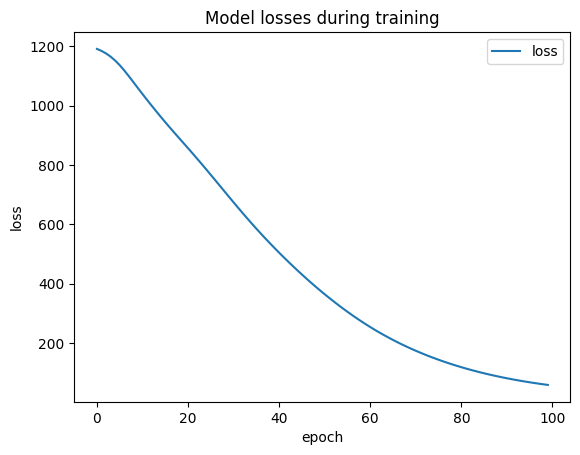

In [ ]:
if start_train:

    plt.plot(history.history["loss"])
    # plt.plot(history.history["regularization_loss"])
    # plt.plot(history.history["total_loss"])
    plt.title("Model losses during training")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["loss"], loc="upper right")
    plt.show()

In [ ]:
if start_train:
    train_accuracy = candidates_model.evaluate(
        cached_train, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]

    test_accuracy = candidates_model.evaluate(
        cached_test, return_dict=True)["factorized_top_k/top_100_categorical_accuracy"]

    print(f"Top-100 accuracy (train): {train_accuracy:.2f}.")
    print(f"Top-100 accuracy (test): {test_accuracy:.2f}.")

11/11 [==============================] - 37s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.5367 - factorized_top_k/top_5_categorical_accuracy: 0.9514 - factorized_top_k/top_10_categorical_accuracy: 0.9794 - factorized_top_k/top_50_categorical_accuracy: 0.9976 - factorized_top_k/top_100_categorical_accuracy: 0.9995 - loss: 964.4078 - regularization_loss: 0.0000e+00 - total_loss: 964.4078
Top-100 accuracy (train): 1.00.
Top-100 accuracy (test): 1.00.


## Get Recommendation

In [32]:
candidates_model.load_weights(filepath='./weights/trained_n_personalized_model')

In [33]:
index = tfrs.layers.factorized_top_k.BruteForce(
    candidates_model.query_model
)

In [ ]:
trained_index = index.index_from_dataset(
  tf.data.Dataset.zip((
    song.batch(100).map(lambda x: x["track_id"]),
    song.batch(100).map(lambda x: {
      'track_id': x["track_id"],
      'song_title': x["song_title"],
      'total_listener': x["total_listener"],
      'artist': x["artist"],
      'Emotion Quadrant': x["Emotion Quadrant"]
      }).map(candidates_model.candidate_model)))
)

index_song = dict(song_df[['track_id','song_title']].to_numpy())

### Function

In [39]:
def get_recommendation(user_id):

  # Get Segment of User
  segment = str(user_df[user_df['user_id'] == user_id]['segment'].values[0])

  # Transform user_id to New Format
  user_id = 'id_' + str(user_id)

  # Get the Most Listening Song of that User
  user_interactions = interaction_df[interaction_df['user_id'] == user_id]
  track_id = user_interactions.groupby('track_id')['playcount'].sum().idxmax()

  # Use the Information to Get the Recommendation
  scores , titles = trained_index(queries = {
    'user_id':tf.constant([user_id]),
    'track_id':tf.constant([track_id]),
    'segment':tf.constant([segment])
    }, k = 10
  )

  titles = [index_song[idx.decode('utf-8')] for idx in titles[0, :].numpy()]

  recommendation_dict = dict(zip(titles, scores.numpy()[0]))

  return recommendation_dict, track_id

In [45]:
def get_recommend_df(user_id):

  recommend_outputs = get_recommendation(user_id)[0]

  # Convert dictionary to DataFrame
  recommend_df = pd.DataFrame({
    'Ranking': range(1, len(recommend_outputs) + 1),
    'Song Titles': [song.split(" by ")[0] for song in recommend_outputs.keys()],
    'Artist': [song.split(" by ")[1] for song in recommend_outputs.keys()],
    'Score': list(recommend_outputs.values())
  })

  return recommend_df

In [40]:
def calculate_accuracy_mood(recommendation_dict):

  mood_dict = {}

  for idx, row in mood_df.iterrows():

    # Combine the name and artist to create the key
    song_artist_key = f"{row['name']} by {row['artist']}"

    # Check if the song is in the dictionary, then update the value with the 'Emotion Quadrant'
    if song_artist_key in recommendation_dict:
        mood_dict[song_artist_key] = row['Emotion Quadrant']

  return mood_dict

### Display Recommendation

In [ ]:
# Recommendation for user 269099
get_recommend_df(269099)

,Ranking,Song Titles,Artist,Score
0,1,Hey Stephen,Taylor Swift,29.426807
1,2,Goodbye My Lover,James Blunt,29.326862
2,3,Fireproof,The National,29.303545
3,4,Yesterday Threw Everything At Me,Athlete,29.270155
4,5,Jewel Box,Jeff Buckley,29.203146
5,6,Skypager,A Tribe Called Quest,29.148966
6,7,The Stranger Song,Leonard Cohen,29.099771
7,8,Nowhere Warm,Kate Havnevik,29.086969
8,9,Going to Your Funeral Part II,Eels,29.074612
9,10,"Pry, To",Pearl Jam,29.072317


# Evaluation

- precision@K

## heavy user (most listeners 600 users)

In [ ]:
heavy_user_listen_df['id'] = heavy_user_listen_df['user_id'].str[3:].astype(int)
heavy_user_listener = heavy_user_listen_df['id'].unique()

In [ ]:
item_df = pd.read_csv('df_items_encoded.csv')
song_info_df = pd.read_csv('df_song_info_encoded.csv')
interaction_df = pd.read_csv('df_interactions_encoded.csv')
user_df = pd.read_csv('df_users_encoded.csv')

mood_df = item_df[['track_id','Emotion Quadrant']]
mood_df = pd.merge(mood_df, song_info_df[['track_id','name','artist']], on='track_id', how='left')

interaction_df = pd.merge(interaction_df, mood_df, on='track_id', how='left')

In [ ]:
interaction_df_filtered = interaction_df[interaction_df['user_id'].isin(heavy_user_listener)]

# Get the index of the rows with the highest playcount for each user_id
idx = interaction_df_filtered.groupby('user_id')['playcount'].idxmax()

# Select those rows from the original dataframe
most_playcount_df = interaction_df_filtered.loc[idx].reset_index(drop=True)

most_playcount_df = pd.merge(most_playcount_df, user_df, on='user_id', how='left')

In [ ]:
most_playcount_df[most_playcount_df['user_id']==heavy_user_listener[0]]['segment']

,user_id,track_id,playcount,Emotion Quadrant,name,artist,segment
80,102396,14545,34,0,5.45,Gang of Four,1


In [ ]:
def get_recommendation(user_id, k):

  # Get segment of user
  segment = str(most_playcount_df[most_playcount_df['user_id'] == user_id]['segment'].values[0])

  # Emotion Quadrant
  emotion = most_playcount_df[most_playcount_df['user_id'] == user_id]['Emotion Quadrant'].values[0]

  # Get the most listening song of that user
  track_id = most_playcount_df[most_playcount_df['user_id'] == user_id]['track_id'].values[0]
  track_id = 'id_' + str(track_id)

  # Transform user_id to new format
  user_id = 'id_' + str(user_id)

  # use the information to get the recommendation
  scores , titles = trained_index(queries = {
    'user_id':tf.constant([user_id]),
    'track_id':tf.constant([track_id]),
    'segment':tf.constant([segment])
    }, k = k
  )

  titles = [index_song[idx.decode('utf-8')] for idx in titles[0, :].numpy()]

  recommendation_dict = dict(zip(titles, scores.numpy()[0]))

  return recommendation_dict, emotion

In [ ]:
def get_mood_dict(recommendation_dict):

    mood_dict = {}

    for idx, row in mood_df.iterrows():
        # Combine the name and artist to create the key
        song_artist_key = f"{row['name']} by {row['artist']}"

        # Check if the song is in the recommendation_dict
        if song_artist_key in recommendation_dict:
            mood_dict[song_artist_key] = row['Emotion Quadrant']

    return mood_dict

In [ ]:
def precision_at_k(heavy_user_listener, k):

  precision_at_k = {}

  for user in heavy_user_listener:

    TP = 0
    FP = 0

    recommendation, emotion = get_recommendation(user, k)
    mood_dict = get_mood_dict(recommendation)

    for mood in mood_dict.values():
      if mood == emotion:
        TP += 1
      else:
        FP += 1

    precision = TP / (TP + FP)
    precision_at_k[user] = precision

  return precision_at_k

In [ ]:
precision_at_5 = precision_at_k(heavy_user_listener, 5)

In [ ]:
# Calculate the average precision
average_precision_at_5 = sum(precision_at_5.values()) / len(precision_at_5)
print(f"Average precision at 5: {average_precision_at_5}")

Average precision at 5: 0.8613333333333341


In [ ]:
precision_at_10 = precision_at_k(heavy_user_listener, 10)

# Calculate the average precision
average_precision_at_10 = sum(precision_at_10.values()) / len(precision_at_10)
print(f"Average precision at 10: {average_precision_at_10}")

Average precision at 10: 0.8425000000000001


In [ ]:
precision_at_20 = precision_at_k(heavy_user_listener, 20)

# Calculate the average precision
average_precision_at_20 = sum(precision_at_20.values()) / len(precision_at_20)
print(f"Average precision at 20: {average_precision_at_20}")

Average precision at 20: 0.8255833333333332


## normal user

In [ ]:
# normal user
light_user_listen_df['id'] = light_user_listen_df['user_id'].str[3:].astype(int)
normal_user_listener = light_user_listen_df['id'].unique()

interaction_df_normal_user_filtered = interaction_df[interaction_df['user_id'].isin(normal_user_listener)]

# Get the index of the rows with the highest playcount for each user_id
idx_2 = interaction_df_normal_user_filtered.groupby('user_id')['playcount'].idxmax()

# Select those rows from the original dataframe
most_playcount_normal_df = interaction_df_normal_user_filtered.loc[idx_2].reset_index(drop=True)

most_playcount_normal_df = pd.merge(most_playcount_normal_df, user_df, on='user_id', how='left')

In [ ]:
# Perform stratified sampling based on the 'Emotion Quadrant' column
stratified_sample, _ = train_test_split(most_playcount_normal_df, test_size=len(most_playcount_normal_df) - 450, stratify=most_playcount_normal_df['Emotion Quadrant'], random_state=13)

sample_user = stratified_sample['user_id'].unique()

interaction_df_sample_filtered = interaction_df_normal_user_filtered[interaction_df_normal_user_filtered['user_id'].isin(sample_user)]

# Get the index of the rows with the highest playcount for each user_id
idx_3 = interaction_df_sample_filtered.groupby('user_id')['playcount'].idxmax()

# Select those rows from the original dataframe
most_playcount_sampled_df = interaction_df_sample_filtered.loc[idx_3].reset_index(drop=True)

most_playcount_sampled_df = pd.merge(most_playcount_sampled_df, user_df, on='user_id', how='left')

In [ ]:
def get_recommendation_2(user_id, k):

  # get segment of user
  segment = str(most_playcount_sampled_df[most_playcount_sampled_df['user_id'] == user_id]['segment'].values[0])

  # Emotion Quadrant
  emotion = most_playcount_sampled_df[most_playcount_sampled_df['user_id'] == user_id]['Emotion Quadrant'].values[0]

  # get the most listening song of that user
  track_id = most_playcount_sampled_df[most_playcount_sampled_df['user_id'] == user_id]['track_id'].values[0]
  track_id = 'id_' + str(track_id)

  # transform user_id to new format
  user_id = 'id_' + str(user_id)


  # use the information to get the recommendation
  scores , titles = trained_index(queries = {
    'user_id':tf.constant([user_id]),
    'track_id':tf.constant([track_id]),
    'segment':tf.constant([segment])
    }, k = k
  )

  titles = [index_song[idx.decode('utf-8')] for idx in titles[0, :].numpy()]

  recommendation_dict = dict(zip(titles, scores.numpy()[0]))

  return recommendation_dict, emotion


def get_mood_dict_2(recommendation_dict):

    mood_dict = {}

    for idx, row in mood_df.iterrows():
        # Combine the name and artist to create the key
        song_artist_key = f"{row['name']} by {row['artist']}"

        # Check if the song is in the recommendation_dict
        if song_artist_key in recommendation_dict:
            mood_dict[song_artist_key] = row['Emotion Quadrant']

    return mood_dict


def precision_at_k_v2(heavy_user_listener, k):

  precision_at_k = {}

  for user in heavy_user_listener:

    TP = 0
    FP = 0

    recommendation, emotion = get_recommendation_2(user, k)
    mood_dict = get_mood_dict_2(recommendation)

    for mood in mood_dict.values():
      if mood == emotion:
        TP += 1
      else:
        FP += 1

    precision = TP / (TP + FP)
    precision_at_k[user] = precision

  return precision_at_k

In [ ]:
normal_user_precision_at_5 = precision_at_k_v2(sample_user, 5)

# Calculate the average precision
average_normal_user_precision_at_5 = sum(normal_user_precision_at_5.values()) / len(normal_user_precision_at_5)
print(f"Average precision at 5: {average_normal_user_precision_at_5}")

Average precision at 5: 0.7546666666666669


In [ ]:
normal_user_precision_at_10 = precision_at_k_v2(sample_user, 10)

# Calculate the average precision
average_normal_user_precision_at_10 = sum(normal_user_precision_at_10.values()) / len(normal_user_precision_at_10)
print(f"Average precision at 10: {average_normal_user_precision_at_10}")

Average precision at 10: 0.7395555555555559


In [ ]:
normal_user_precision_at_20 = precision_at_k_v2(sample_user, 20)

# Calculate the average precision
average_normal_user_precision_at_20 = sum(normal_user_precision_at_20.values()) / len(normal_user_precision_at_20)
print(f"Average precision at 20: {average_normal_user_precision_at_20}")

Average precision at 20: 0.7245555555555551
